In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

In [11]:
def MNIST_loaders(train_batch_size=512, test_batch_size=512):
    # Define a series of image transformations using Compose
    transform = Compose([
        # Convert images to PyTorch tensors
        ToTensor(),
        # Normalize the pixel values of the images
        Normalize((0.1307,), (0.3081,)),
        # Flatten the image tensors
        Lambda(lambda x: torch.flatten(x))])
    # Create a DataLoader for the training set
    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    # Create a DataLoader for the test set
    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

def overlay_y_on_x(x, y):
    x_ = x.clone()
    # Set the first 10 pixels of each sample to 0
    x_[:, :10] *= 0.0
    # Set the value of the one-hot-encoded label [y] at the corresponding position
    x_[range(x.shape[0]), y] = x.max()
    return x_

# Plot a sample data
def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

In [15]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        # Create a ReLU activation function
        self.relu = torch.nn.ReLU()
        # Initialize an Adam optimizer with a learning rate of 0.03 for the layer parameters
        self.opt = Adam(self.parameters(), lr=0.01)
        # Set a threshold value for the layer
        self.threshold = 2.0
        # Set the number of training epochs
        self.num_epochs = 1000

    def forward(self, x):
        # Normalize the input data along each sample's direction
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        # Perform the forward pass through the layer using ReLU activation
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # Calculate squared activations for positive and negative samples
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # Formulate a loss function to push positive samples towards values larger
            # and negative samples towards values smaller than the threshold
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            # Zero the gradients of the optimizer
            self.opt.zero_grad()
            # Perform backward pass to compute derivatives (not considered backpropagation)
            loss.backward()
            # Update the parameters of the layer using the optimizer
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [4]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        # Initialize a list to store the layers of the neural network
        self.layers = []
        # Iterate over the dimensions and create Layer instances for each pair of consecutive dimensions
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]

    def predict(self, x):
        # Initialize a list to store goodness values for each label
        goodness_per_label = []
        for label in range(10):
            # Overlay the input data with the one-hot-encoded label
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                # Pass the data through the layer and calculate squared activations
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        # Concatenate the goodness values for each label along dimension 1
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print(f'Training Layer {i + 1}/{len(self.layers)} - Input Size: {layer.in_features}, Output Size: {layer.out_features}')
            # Train the current layer and update positive and negative samples
            h_pos, h_neg = layer.train(h_pos, h_neg)

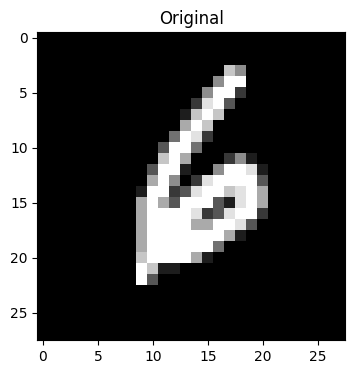

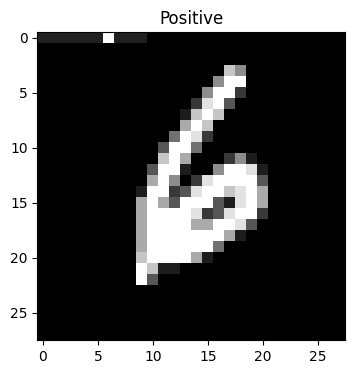

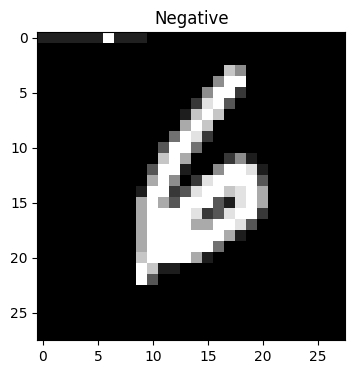

Training Layer 1/2 - Input Size: 784, Output Size: 500


100%|██████████| 1000/1000 [00:24<00:00, 41.51it/s]


Training Layer 2/2 - Input Size: 500, Output Size: 500


100%|██████████| 1000/1000 [00:15<00:00, 62.84it/s]



Training Error: 0.1367
Number of Correct Predictions: 442/512
Accuracy: 86.33%
Test Error: 0.2656
Number of Correct Predictions: 376/512
Accuracy: 73.44%


In [16]:
if __name__ == "__main__":
    # Set a fixed seed for reproducibility
    torch.manual_seed(1)

    # Load training and test data using MNIST loaders
    train_loader, test_loader = MNIST_loaders()

    # Load training and test data using MNIST loaders
    net = Net([784, 500, 500])

    # Extract a batch of training data
    x, y = next(iter(train_loader))
    x, y = x, y

    # Overlay the input data with one-hot-encoded labels for positive samples
    x_pos = overlay_y_on_x(x, y)

    # Create negative samples by overlaying input data with randomly permuted labels
    rnd = torch.randperm(x.size(0))
    x_neg = overlay_y_on_x(x, y[rnd])

    # Visualize the original, positive, and negative samples
    for data, name in zip([x, x_pos, x_neg], ['Original', 'Positive', 'Negative']):
        visualize_sample(data, name)

    # Train the neural network using positive and negative samples
    net.train(x_pos, x_neg)

    # Calculate the training error
    prediction = net.predict(x)
    correct_predictions = prediction.eq(y).float()
    accuracy = correct_predictions.mean().item()
    training_error = 1.0 - accuracy

    # Print the training error with detailed information
    print(f'\nTraining Error: {training_error:.4f}')
    print(f'Number of Correct Predictions: {int(correct_predictions.sum())}/{len(y)}')
    print(f'Accuracy: {accuracy:.2%}')

    # Extract a batch of test data
    x_te, y_te = next(iter(test_loader))
    x_te, y_te = x_te, y_te

    # Calculate the test error
    test_prediction = net.predict(x_te)
    test_correct_predictions = test_prediction.eq(y_te).float()
    test_accuracy = test_correct_predictions.mean().item()
    test_error = 1.0 - test_accuracy

    # Print the test error with detailed information
    print(f'Test Error: {test_error:.4f}')
    print(f'Number of Correct Predictions: {int(test_correct_predictions.sum())}/{len(y_te)}')
    print(f'Accuracy: {test_accuracy:.2%}')
